In [1]:
import time
import pickle
import math
import pandas as pd
import numpy as np
import scipy.sparse
from sklearn import preprocessing

In [2]:
SUBMISSION = False
SUBMISSION_FILENAME = 'submission.csv'
TEST_FILENAME = 'test.csv'

In [3]:
target_playlists = pd.read_csv('../datasets/target_playlists.csv', sep='\t')
target_tracks = pd.read_csv('../datasets/target_tracks.csv', sep='\t')
tracks_final = pd.read_csv('../datasets/tracks_final.csv', sep='\t')
playlists_final = pd.read_csv('../datasets/playlists_final.csv', sep='\t')
train_final = pd.read_csv('../datasets/train_final.csv', sep='\t')

print('Successfully read data')

Successfully read data


In [4]:
def check_matrix(X, format='csc', dtype=np.float32):
    if format == 'csc' and not isinstance(X, scipy.sparse.csc_matrix):
        return X.tocsc().astype(dtype)
    elif format == 'csr' and not isinstance(X, scipy.sparse.csr_matrix):
        return X.tocsr().astype(dtype)
    elif format == 'coo' and not isinstance(X, scipy.sparse.coo_matrix):
        return X.tocoo().astype(dtype)
    elif format == 'dok' and not isinstance(X, scipy.sparse.dok_matrix):
        return X.todok().astype(dtype)
    elif format == 'bsr' and not isinstance(X, scipy.sparse.bsr_matrix):
        return X.tobsr().astype(dtype)
    elif format == 'dia' and not isinstance(X, scipy.sparse.dia_matrix):
        return X.todia().astype(dtype)
    elif format == 'lil' and not isinstance(X, scipy.sparse.lil_matrix):
        return X.tolil().astype(dtype)
    else:
        return X.astype(dtype)

In [5]:
def is_relevant(recommendation_item, validation_set):
    validation_item = validation_set.loc[validation_set['playlist_id'] == recommendation_item['playlist_id']]
    recommendation_item['recommendation'] = pd.Series(recommendation_item['recommendation'])\
                                                .isin(list(validation_item['track_id']))
    return recommendation_item


def precision(recommended_items_relevance):
    precision_scores = recommended_items_relevance.sum(axis=1) / recommended_items_relevance.shape[1]
    return precision_scores.mean()


def mAP(recommended_items_relevance):
    p_at_k = recommended_items_relevance.cumsum(axis=1) / (1 + np.arange(recommended_items_relevance.shape[1]))
    recommended_items_mAP = p_at_k.sum(axis=1) / recommended_items_relevance.shape[1]
    return recommended_items_mAP.mean()


def evaluate_recommendations(recommended_items, validation_set):
    items_relevance = recommended_items.apply(lambda recommendation_item: is_relevant(recommendation_item, validation_set), axis=1)
    recommended_items_relevance = pd.DataFrame(list(items_relevance['recommendation']), index=items_relevance['recommendation'].index)
    precision_score = precision(recommended_items_relevance)
    mAP_score = mAP(recommended_items_relevance)
    return precision_score, mAP_score

def evaluate(recommended_items, validation_set):
    print('Evaluating...')
    begin = time.time()
    precision_score, mAP_score = evaluate_recommendations(recommended_items, validation_set)
    print('Precision: {0:.{digits}f}, mAP: {1:.{digits}f}, took {2:.{digits}f}s'
          .format(precision_score, mAP_score, time.time() - begin, digits=5))

In [6]:
print('Data info:')
print('Unique tracks count: {}'.format(tracks_final['track_id'].nunique()))
print('Unique playlist count: {}'.format(playlists_final['playlist_id'].nunique()))
print('Target tracks count: {}'.format(target_tracks['track_id'].nunique()))
print('Target playlists count: {}'.format(target_playlists['playlist_id'].nunique()))

Data info:
Unique tracks count: 100000
Unique playlist count: 57561
Target tracks count: 32195
Target playlists count: 10000


In [7]:
track_id_le = preprocessing.LabelEncoder()
track_id_le.fit(list(tracks_final['track_id']))
print('track_id_le classes: {}'.format(len(track_id_le.classes_)))

playlist_id_le = preprocessing.LabelEncoder()
playlist_id_le.fit(list(playlists_final['playlist_id']))
print('playlist_id_le classes: {}'.format(len(playlist_id_le.classes_)))

track_id_le classes: 100000
playlist_id_le classes: 57561


In [8]:
# Playlist and tracks that belong to them
target_playlists_and_tracks = pd.merge(target_playlists, train_final, on='playlist_id')
print('target_playlists_and_tracks {}'.format(target_playlists_and_tracks.shape))
print(target_playlists_and_tracks.head(10))

target_playlists_and_tracks (362661, 2)
   playlist_id  track_id
0     10024884   2879006
1     10024884   1532328
2     10024884   3027673
3     10024884   3236144
4     10024884   1563134
5     10024884    435345
6     10024884    353291
7     10024884    247331
8     10024884    161455
9     10024884   3338954


In [9]:
def split_training_data(train_final, target_playlists_and_tracks, random_state):
    validation_set = target_playlists_and_tracks.groupby(['playlist_id'])\
                        .apply(lambda x: x.sample(n=3, random_state=random_state))\
                        .reset_index(drop=True)
    df_concat = pd.concat([train_final, validation_set])
    training_set = df_concat.drop_duplicates(keep=False)
    return training_set, validation_set

# Split dataset - from all target playlists remove randomly 3 tracks
training_set, validation_set = split_training_data(train_final, target_playlists_and_tracks, random_state=0)
test_target_tracks = validation_set['track_id'].drop_duplicates(keep='first').to_frame()
test_target_tracks['transformed_track_id'] = track_id_le.transform(list(test_target_tracks['track_id']))
target_tracks['transformed_track_id'] = track_id_le.transform(list(target_tracks['track_id']))

training_set['transformed_track_id'] = track_id_le.transform(list(training_set['track_id']))
training_set['transformed_playlist_id'] = playlist_id_le.transform(list(training_set['playlist_id']))
target_playlists['transformed_playlist_id'] = playlist_id_le.transform(list(target_playlists['playlist_id']))

print('training_set: {}'.format(training_set.shape))
print(training_set.head(5))
print('validation_set: {}'.format(validation_set.shape))
print(validation_set.head(5))
print('test_target_tracks: {}'.format(test_target_tracks.shape))
print(test_target_tracks.head(5))

training_set: (1010522, 4)
   playlist_id  track_id  transformed_track_id  transformed_playlist_id
0      3271849   2801526                 71058                     8890
1      5616275    727878                 19741                    22426
2     11267488   2805283                 71298                    54743
3     10103900   1515105                 36851                    46970
4      3836898   2945623                 76310                    11967
validation_set: (30000, 2)
   playlist_id  track_id
0         7614   2141817
1         7614   3833025
2         7614   3711434
3         7692   2053595
4         7692   2172361
test_target_tracks: (21958, 2)
   track_id  transformed_track_id
0   2141817                 53522
1   3833025                 97760
2   3711434                 94876
3   2053595                 51310
4   2172361                 54282


In [10]:
urm_ones = np.ones(training_set.shape[0])
print('urm_ones shape: {}, vector: {}'.format(urm_ones.shape, urm_ones))

URM = scipy.sparse.coo_matrix((urm_ones, (list(training_set['transformed_track_id']),
                                          list(training_set['transformed_playlist_id']))))
print(URM.shape)
playlists_per_track = (URM > 0).sum(axis=1)
tracks_per_playlist = (URM > 0).sum(axis=0)

print('playlists_per_track.shape {}'.format(playlists_per_track.shape))
print('tracks_per_playlist.shape {}'.format(tracks_per_playlist.shape))

urm_ones shape: (1010522,), vector: [ 1.  1.  1. ...,  1.  1.  1.]
(100000, 57561)
playlists_per_track.shape (100000, 1)
tracks_per_playlist.shape (1, 57561)


In [11]:
num_tot_tracks = URM.shape[0]
tracks_per_playlist = (URM > 0).sum(axis=0)
IDF = np.array(np.log(num_tot_tracks / (tracks_per_playlist + 1)))[0]
URM_idf = URM.copy()
# compute the number of non-zeros in each col
# NOTE: this works only if X is instance of sparse.csc_matrix
col_nnz = np.diff(check_matrix(URM_idf, 'csc').indptr)
print(col_nnz.shape)
print(URM_idf.shape)
print(IDF.shape)
# then normalize the values in each col
URM_idf.data *= np.repeat(IDF, col_nnz)

(57561,)
(100000, 57561)
(57561,)


In [12]:
playlists_per_track = np.array(playlists_per_track).squeeze()
tracks_per_playlist = np.array(tracks_per_playlist).squeeze()

print(playlists_per_track.shape)
print(tracks_per_playlist.shape)

playlists_per_track = np.sort(playlists_per_track)
tracks_per_playlist = np.sort(tracks_per_playlist)

(100000,)
(57561,)


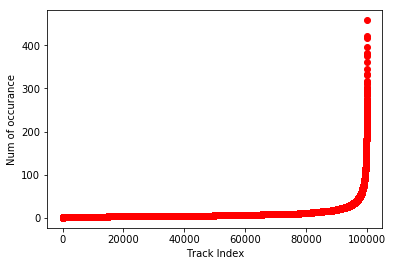

In [13]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(playlists_per_track, 'ro')
pyplot.ylabel('Num of occurance')
pyplot.xlabel('Track Index')
pyplot.show()

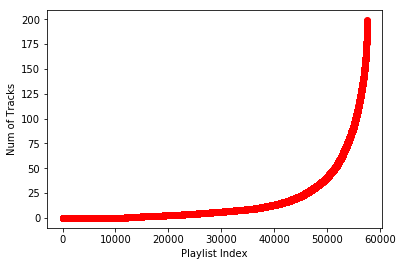

In [14]:
pyplot.plot(tracks_per_playlist, 'ro')
pyplot.ylabel('Num of Tracks')
pyplot.xlabel('Playlist Index')
pyplot.show()

In [15]:
class ISimilarity(object):
    """Abstract interface for the similarity metrics"""

    def __init__(self, shrinkage=10):
        self.shrinkage = shrinkage

    def compute(self, X):
        pass


class Cosine(ISimilarity):
    def compute(self, X):
        # convert to csc matrix for faster column-wise operations
        X = check_matrix(X, 'csc', dtype=np.float32)

        # 1) normalize the columns in X
        # compute the column-wise norm
        # NOTE: this is slightly inefficient. We must copy X to compute the column norms.
        # A faster solution is to  normalize the matrix inplace with a Cython function.
        Xsq = X.copy()
        Xsq.data **= 2
        norm = np.sqrt(Xsq.sum(axis=0))
        norm = np.asarray(norm).ravel()
        norm += 1e-6
        # compute the number of non-zeros in each column
        # NOTE: this works only if X is instance of sparse.csc_matrix
        
        col_nnz = np.diff(X.indptr)
        # then normalize the values in each column
        X.data /= np.repeat(norm, col_nnz)
        print("Normalized")

        # 2) compute the cosine similarity using the dot-product
        print("Computing distance")
        dist = X * X.T
        print("Computed")

        # and apply the shrinkage
        if self.shrinkage > 0:
            dist = self.apply_shrinkage(X, dist)
            print("Applied shrinkage")    
        
        return dist

    def apply_shrinkage(self, X, dist):
        # create an "indicator" version of X (i.e. replace values in X with ones)
        X_ind = X.copy()
        X_ind.data = np.ones_like(X_ind.data)
        # compute the co-rated counts
        co_counts = X_ind * X_ind.T
        # remove the diagonal
#         co_counts = co_counts - scipy.sparse.dia_matrix((co_counts.diagonal()[scipy.newaxis, :], [0]), shape=co_counts.shape)
        # compute the shrinkage factor as co_counts_ij / (co_counts_ij + shrinkage)
        # then multiply dist with it
        co_counts_shrink = co_counts.copy()
        co_counts_shrink.data += self.shrinkage
        co_counts.data /= co_counts_shrink.data
        dist.data *= co_counts.data
        return dist

In [16]:
distance = Cosine(shrinkage=1)
items_similarity = distance.compute(URM_idf)
# items_similarity = distance.compute(URM)

Normalized
Computing distance
Computed
Applied shrinkage


In [21]:
class ItemBasedRecommender:
    def __init__(self, to_predict=3):
        self.to_predict = to_predict
    
    def fit(self, training_set, target_tracks, items_similarity):
        self.training_set = training_set
        self.items_similarity = items_similarity
        
        self.target_tracks_mask = np.zeros(self.items_similarity.shape[0])
        for value in list(target_tracks['transformed_track_id']):
            self.target_tracks_mask[value] = 1
    
    def recommend(self, target_playlists):
        def make_recommendation(playlist):
            tracks_on_playlist = self.training_set.loc[self.training_set['playlist_id'] == playlist['playlist_id']]
            transformed_tracks_on_playlist = track_id_le.transform(list(tracks_on_playlist['track_id']))
            tracks_on_playlist_mask = np.ones(self.items_similarity.shape[0])
            for value in transformed_tracks_on_playlist:
                tracks_on_playlist_mask[value] = 0

            correlation = np.squeeze(np.asarray(self.items_similarity[:, transformed_tracks_on_playlist].sum(axis=1)))
            correlation = correlation * self.target_tracks_mask
            correlation = correlation * tracks_on_playlist_mask
            ind = np.argpartition(list(correlation), -self.to_predict)[-self.to_predict:]
            scores = np.take(correlation, ind)
        
            ind, scores = zip(*sorted(zip(ind, scores), key=lambda x: x[1], reverse=True))

            recommended_tracks = track_id_le.inverse_transform(ind)
            playlist['recommendation'] = list(recommended_tracks)
            playlist['scores'] = list(scores)
            return playlist
        recommended_items = target_playlists.apply(lambda playlist: make_recommendation(playlist), axis=1)
        return recommended_items


In [22]:
print('Building model...')
begin = time.time()
recommender = ItemBasedRecommender()
recommender.fit(training_set, test_target_tracks, items_similarity)
# recommender.fit(train_final, target_tracks, item_similarity)
print('Took {0:.{digits}f}s'.format(time.time() - begin, digits=5))

Building model...
Took 0.00819s


In [23]:
print('Recommending...')
begin = time.time()
recommended_items = recommender.recommend(target_playlists.head(100))
print('Took {0:.{digits}f}s'.format(time.time() - begin, digits=5))

print('recommended_items {}'.format(recommended_items.shape))
print(recommended_items.head(3))

Recommending...
Took 3.00871s
recommended_items (100, 4)
   playlist_id  transformed_playlist_id               recommendation  \
0     10024884                    46297   [2730084, 204966, 3346814]   
1     10624787                    50898  [1563309, 1764811, 1705891]   
2      4891851                    17907  [1040777, 2413921, 2716989]   

                                             scores  
0    [1.46280038357, 1.07050812244, 0.984080612659]  
1  [0.729912817478, 0.414651840925, 0.399835407734]  
2   [0.323885470629, 0.268402576447, 0.26541569829]  


In [24]:
if not SUBMISSION:
    evaluate(recommended_items, validation_set)

Evaluating...
Precision: 0.07000, mAP: 0.07500, took 0.14165s


In [35]:
def print_results(recommended_items, filename):
    print('Printing...')
    with open('./submissions/{}'.format(filename), 'w') as output_file:
        output_file.write('playlist_id,track_ids\n')
        for index, recommendation in recommended_items.iterrows():
            row = '{},'.format(recommendation['playlist_id'])
            for track_id in pd.Series(recommendation['recommendation']).values:
                row += ' {}'.format(track_id)
            row += '\n'
            output_file.write(row)
print_results(recommended_items, filename=SUBMISSION_FILENAME if SUBMISSION else TEST_FILENAME)

Printing...


In [56]:
def print_validation_set(validation_set):
    print('Printing...')
    with open('./submissions/validationset.csv', 'w') as output_file:
        output_file.write('playlist_id,track_ids\n')
        for index, validation_row in validation_set.iterrows():
            if index % 3 == 0:
                playlist_id = '{},'.format(validation_row['playlist_id'])
                output_file.write(playlist_id)
            track_id = ' {}'.format(validation_row['track_id'])
            output_file.write(track_id)

            if index % 3 == 2:
                output_file.write('\n')
print_validation_set(validation_set)

Printing...
